# Data Analysis

### Imports & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set_style("whitegrid")
sns.set_context("notebook")

### Tables


In [2]:
# 1. Load Data
column_names = [
    "reference", "location", "price", "title", "bedrooms", 
    "bathrooms", "indoor_surface", "outdoor_surface", "features"
]

df = pd.read_csv("data/properties.csv", header=None, names=column_names, na_values="NA")

In [3]:
# 2. Data Cleaning & Feature Engineering

# --- A. Numeric Cleaning ---
# Price: Remove symbols and convert
df['price'] = df['price'].astype(str).str.replace('€', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Other numeric columns
numeric_cols = ['bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# --- B. Splitting Columns (NEW) ---

# 1. Split 'location' (Address) -> City, Region
# Assuming format "City, Region" (e.g., "Marbella, Costa del Sol")
location_split = df['location'].str.split(',', n=1, expand=True)
df['city'] = location_split[0].str.strip()
df['region'] = location_split[1].str.strip()

# 2. Split 'title' (X Bedroom Homes) -> Property Type
# Example: "2 Bedroom Apartment" -> "Apartment"
# We remove the leading number and "Bedroom/Bedrooms" text
df['property_type'] = df['title'].astype(str).str.replace(r'^\d+\s*Bedrooms?\s*', '', regex=True).str.strip()

# (Optional Data Quality Helper) Extract bedroom count from title to check consistency later
df['bedrooms_from_title'] = df['title'].astype(str).str.extract(r'^(\d+)\s*Bedroom').astype(float)

# 3. Split 'features' (Pipe-separated) -> Binary Columns
df['features'] = df['features'].fillna('')
feature_dummies = df['features'].str.get_dummies(sep='|')
# Add prefix to distinguish these from other columns if needed, or keep as is
df = pd.concat([df, feature_dummies], axis=1)

# Remove duplicate columns if any were created
df = df.loc[:, ~df.columns.duplicated()]

# Display basic info
display(df.columns)
display(df.head())

Index(['reference', 'location', 'price', 'title', 'bedrooms', 'bathrooms',
       'indoor_surface', 'outdoor_surface', 'features', 'city',
       ...
       'U/F Heating Climate Control', 'Underground Parking', 'Urban Views',
       'Urbanisation', 'Utility Room', 'Village', 'West Orientation', 'WiFi',
       'With Planning Permission', 'Wood Flooring'],
      dtype='object', length=160)

,reference,location,price,title,bedrooms,bathrooms,indoor_surface,outdoor_surface,features,city,...,U/F Heating Climate Control,Underground Parking,Urban Views,Urbanisation,Utility Room,Village,West Orientation,WiFi,With Planning Permission,Wood Flooring
0,R126116,"Nueva Andalucía, Costa del Sol",450000,3 Bedroom Apartment,3.0,2.0,120.0,NaN,Close to Shops|Electricity Utilities|Close to ...,Nueva Andalucía,...,0,0,0,1,0,0,0,0,0,0
1,R132516,"Puerto Banús, Costa del Sol",1250000,Other,1.0,504.0,NaN,NaN,Electricity Utilities|Close to Town|Street Vie...,Puerto Banús,...,0,1,0,0,0,0,1,0,0,0
2,R121563,"Antequera, Costa del Sol",749000,12 Bedroom Finca,12.0,7.0,366.0,5353.0,Mountain Views|Private Garden|Open Parking|Urb...,Antequera,...,0,0,1,0,0,0,0,0,0,0
3,R127293,"La Mairena, Costa del Sol",500000,Plot,3470.0,NaN,NaN,NaN,Mountain Views|Private Garden|Electricity Util...,La Mairena,...,0,0,0,1,0,0,0,0,1,0
4,R114041,"Benalmadena, Costa del Sol",1695000,4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,Private Garden|Electricity Utilities|Drinkable...,Benalmadena,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# 3. Define Variable Types

# Update Categorical to include newly created columns
# We exclude 'features' (raw string) and 'location' (raw string) in favor of split versions if preferred,
# but keeping 'location' is fine for reference.
categoricalFeatures = ["city", "region", "property_type", "title"] 
display(categoricalFeatures)

# Continuous
continuousFeatures = ["price", "bedrooms", "bathrooms", "indoor_surface", "outdoor_surface"]
display(continuousFeatures)

# Binary Features
binaryFeatures = feature_dummies.columns.tolist()
# display(binaryFeatures)

['city', 'region', 'property_type', 'title']

['price', 'bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']

### Continuous Summary

In [7]:
continuous_summary = df[continuousFeatures].describe(include='all').T
continuous_summary['cardinality'] = df[continuousFeatures].nunique()
continuous_summary['missing_%'] = (df[continuousFeatures].isnull().sum() / len(df)) * 100

continuous_summary = continuous_summary.rename(columns={
    'count': 'total_number_of_values',
    '25%': '1st_quartile',
    '50%': 'median',
    '75%': '3rd_quartile',
    'min': 'minimum',
    'max': 'maximum',
    'std': 'standard_deviation'
})

display(continuous_summary)

,total_number_of_values,mean,standard_deviation,minimum,1st_quartile,median,3rd_quartile,maximum,cardinality,missing_%
price,12086.0,1.046977e+06,1.881298e+06,4500.0,285000.0,475000.0,995000.00,50000000.0,1717,0.000000
bedrooms,12084.0,2.533518e+03,9.853142e+04,0.0,2.0,3.0,5.00,9700000.0,904,0.016548
bathrooms,10952.0,1.076485e+03,4.636483e+04,0.0,2.0,2.0,4.00,4630000.0,453,9.382757
indoor_surface,10414.0,2.334892e+02,2.650649e+02,10.0,100.0,144.5,268.75,5367.0,923,13.834188
outdoor_surface,3821.0,1.113215e+04,1.960650e+05,1.0,401.0,1009.0,2342.00,9350000.0,1797,68.384908


### Categorical Summary

In [8]:
categorical_summary_list = []
for feature in categoricalFeatures:
    total_values = df[feature].count()
    missing_percentage = (df[feature].isnull().sum() / len(df)) * 100
    cardinality = df[feature].nunique()
    value_counts = df[feature].value_counts()
    
    mode_1 = value_counts.index[0] if not value_counts.empty else 'N/A'
    mode_1_freq = value_counts.iloc[0] if not value_counts.empty else 0
    mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
    
    mode_2 = value_counts.index[1] if cardinality > 1 else 'N/A'
    
    categorical_summary_list.append({
        'feature': feature, 'count': total_values, 'missing_%': missing_percentage,
        'cardinality': cardinality, 'mode': mode_1, 'mode_freq': mode_1_freq, 'mode_%': mode_1_perc,
        'mode_2': mode_2
    })

categorical_summary = pd.DataFrame(categorical_summary_list).set_index('feature')
display(categorical_summary)

,count,missing_%,cardinality,mode,mode_freq,mode_%,mode_2
feature,,,,,,,
city,12086,0.0,226,Estepona,1062,8.787026,Nueva Andalucía
region,12086,0.0,2,Costa del Sol,11992,99.222241,Málaga Ciudad
property_type,12086,0.0,39,Apartment,3968,32.831375,Detached Villa
title,12086,0.0,160,2 Bedroom Apartment,2043,16.903856,3 Bedroom Apartment


### Data Issues

In [10]:
df = df.loc[:, ~df.columns.duplicated()]

In [11]:
# --- 1. Check for Missing Values ---
print("--- 1. Missing Values Check ---")
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_values, missing_percentage], axis=1)
missing_table = missing_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

# Filter to show only columns with missing values
missing_table = missing_table[missing_table.iloc[:,0] != 0]

if missing_table.empty:
    print("Congratulations! No missing values found.\n")
else:
    print("Found missing values in the following columns (Top 10):")
    display(missing_table.sort_values('% of Total Values', ascending=False).head(10).round(2))

--- 1. Missing Values Check ---
Found missing values in the following columns (Top 10):


,Missing Values,% of Total Values
outdoor_surface,8265,68.38
bedrooms_from_title,1711,14.16
indoor_surface,1672,13.83
bathrooms,1134,9.38
bedrooms,2,0.02


In [12]:
# --- 2. Check for Duplicate Rows ---
print("\n--- 2. Duplicate Rows Check ---")
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Found {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found.\n")


--- 2. Duplicate Rows Check ---
Found 61 duplicate rows in the dataset.


In [13]:
# --- 3. Check for Constant or Quasi-Constant Columns ---
print("\n--- 3. Constant Columns Check ---")
# Columns with only one unique value (or 0 variance) provide no info
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"The following columns have only 1 unique value (constant): {constant_cols[:5]} ... (Total: {len(constant_cols)})")
else:
    print("No constant columns found.")


--- 3. Constant Columns Check ---
No constant columns found.


In [14]:
# --- 4. Categorical Inconsistencies ---
print("\n--- 4. Categorical Data Quality ---")
# Check for potential data entry errors in main categorical columns
for col in categoricalFeatures:
    if col not in df.columns: continue
    
    print(f"Analyzing '{col}':")
    
    # A. Check for Whitespace/Casing Duplicates
    # e.g., "Villa" vs "villa "
    raw_uniques = df[col].dropna().unique()
    clean_uniques = df[col].dropna().str.strip().str.title().unique()
    
    if len(raw_uniques) != len(clean_uniques):
        print("  [!] Potential inconsistencies found (case/whitespace differences).")
        print(f"      Original unique count: {len(raw_uniques)}, Cleaned unique count: {len(clean_uniques)}")
        print(f"      Example: {list(set(raw_uniques) - set(clean_uniques))[:3]}")
    else:
        print("  Categories look consistent (no casing/trimming issues).")
        
# B. Check for Rare Labels (Typos)
    value_counts = df[col].value_counts()
    rare_labels = value_counts[value_counts < 2] # Appears only once
    if not rare_labels.empty:
        print(f"  [!] Found {len(rare_labels)} rare categories (appearing only once). Potential typos.")
    print("-" * 20)


--- 4. Categorical Data Quality ---
Analyzing 'city':
  Categories look consistent (no casing/trimming issues).
  [!] Found 34 rare categories (appearing only once). Potential typos.
--------------------
Analyzing 'region':
  Categories look consistent (no casing/trimming issues).
--------------------
Analyzing 'property_type':
  Categories look consistent (no casing/trimming issues).
  [!] Found 3 rare categories (appearing only once). Potential typos.
--------------------
Analyzing 'title':
  Categories look consistent (no casing/trimming issues).
  [!] Found 50 rare categories (appearing only once). Potential typos.
--------------------


In [15]:
# --- 5. Data Integrity: Bedrooms vs Title ---
# Check if "3 Bedroom Apartment" actually has 3 in the bedrooms column
print("\n--- 5. Data Integrity: Title vs Bedroom Column ---")
# Compare where both are not NaN
integrity_check = df.dropna(subset=['bedrooms', 'bedrooms_from_title'])
mismatches = integrity_check[integrity_check['bedrooms'] != integrity_check['bedrooms_from_title']]

if not mismatches.empty:
    print(f"[!] Found {len(mismatches)} rows where 'bedrooms' column does not match the title description.")
    print("Example mismatches:")
    display(mismatches[['title', 'bedrooms', 'bedrooms_from_title']].head())
else:
    print("Bedroom counts in Title and Column match perfectly.")



--- 5. Data Integrity: Title vs Bedroom Column ---
Bedroom counts in Title and Column match perfectly.


In [16]:
# --- 5. Numerical Validity & Skewness ---
print("\n--- 5. Numerical Logic & Distribution ---")

# A. Negative Values Check
print("Checking for illogical negative values...")
impossible_negatives = ['price', 'indoor_surface', 'outdoor_surface', 'bedrooms', 'bathrooms']
for col in impossible_negatives:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f"  [!] Warning: '{col}' has {neg_count} negative values.")
        else:
            print(f"  '{col}' is clean (no negatives).")

# B. Skewness Check
print("\nChecking Skewness (Threshold: > 1 or < -1)...")
skewness = df[continuousFeatures].skew()
high_skew = skewness[abs(skewness) > 1]
if not high_skew.empty:
    print("The following variables are highly skewed (indicating potential outliers):")
    print(high_skew)
else:
    print("No highly skewed variables found.")


--- 5. Numerical Logic & Distribution ---
Checking for illogical negative values...
  'price' is clean (no negatives).
  'indoor_surface' is clean (no negatives).
  'outdoor_surface' is clean (no negatives).
  'bedrooms' is clean (no negatives).
  'bathrooms' is clean (no negatives).

Checking Skewness (Threshold: > 1 or < -1)...
The following variables are highly skewed (indicating potential outliers):
price               7.670615
bedrooms           83.166552
bathrooms          92.041640
indoor_surface      5.708034
outdoor_surface    36.865489
dtype: float64



--- 6. Outlier Detection (IQR Method) ---
Outliers found in 'price': 1375 (11.4%)
Outliers found in 'bedrooms': 1557 (12.9%)
Outliers found in 'bathrooms': 755 (6.9%)
Outliers found in 'indoor_surface': 932 (8.9%)
Outliers found in 'outdoor_surface': 466 (12.2%)

Generating boxplots for visual confirmation...


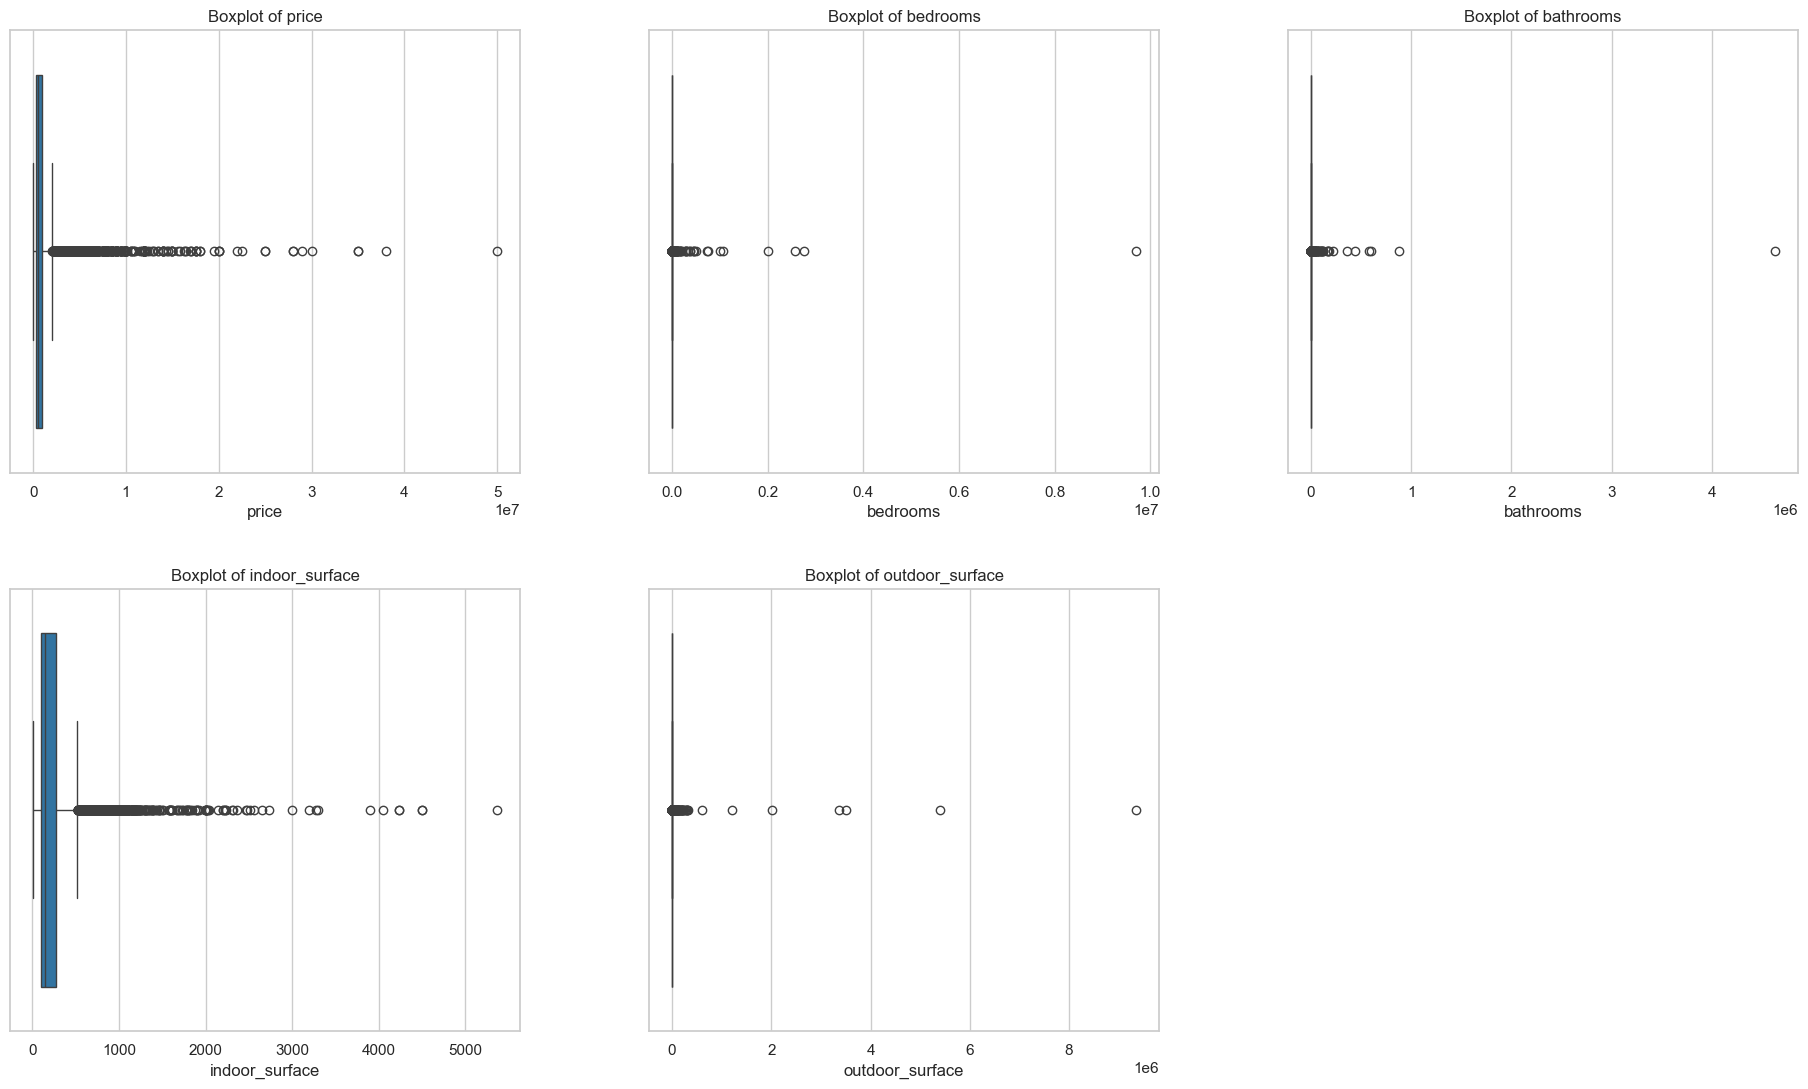

In [17]:
# --- 6. Outlier Detection (IQR) ---
print("\n--- 6. Outlier Detection (IQR Method) ---")
for col in continuousFeatures:
    valid_data = df[col].dropna()
    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
    
    if not outliers.empty:
        print(f"Outliers found in '{col}': {len(outliers)} ({len(outliers)/len(valid_data)*100:.1f}%)")
    else:
        print(f"No outliers found in '{col}'.")

print("\nGenerating boxplots for visual confirmation...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = axes.flatten()
for i in range(len(continuousFeatures)):
    col = continuousFeatures[i]
    sns.boxplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f"Boxplot of {col}")

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig('images/boxplots.pdf')
plt.show()

### Histograms

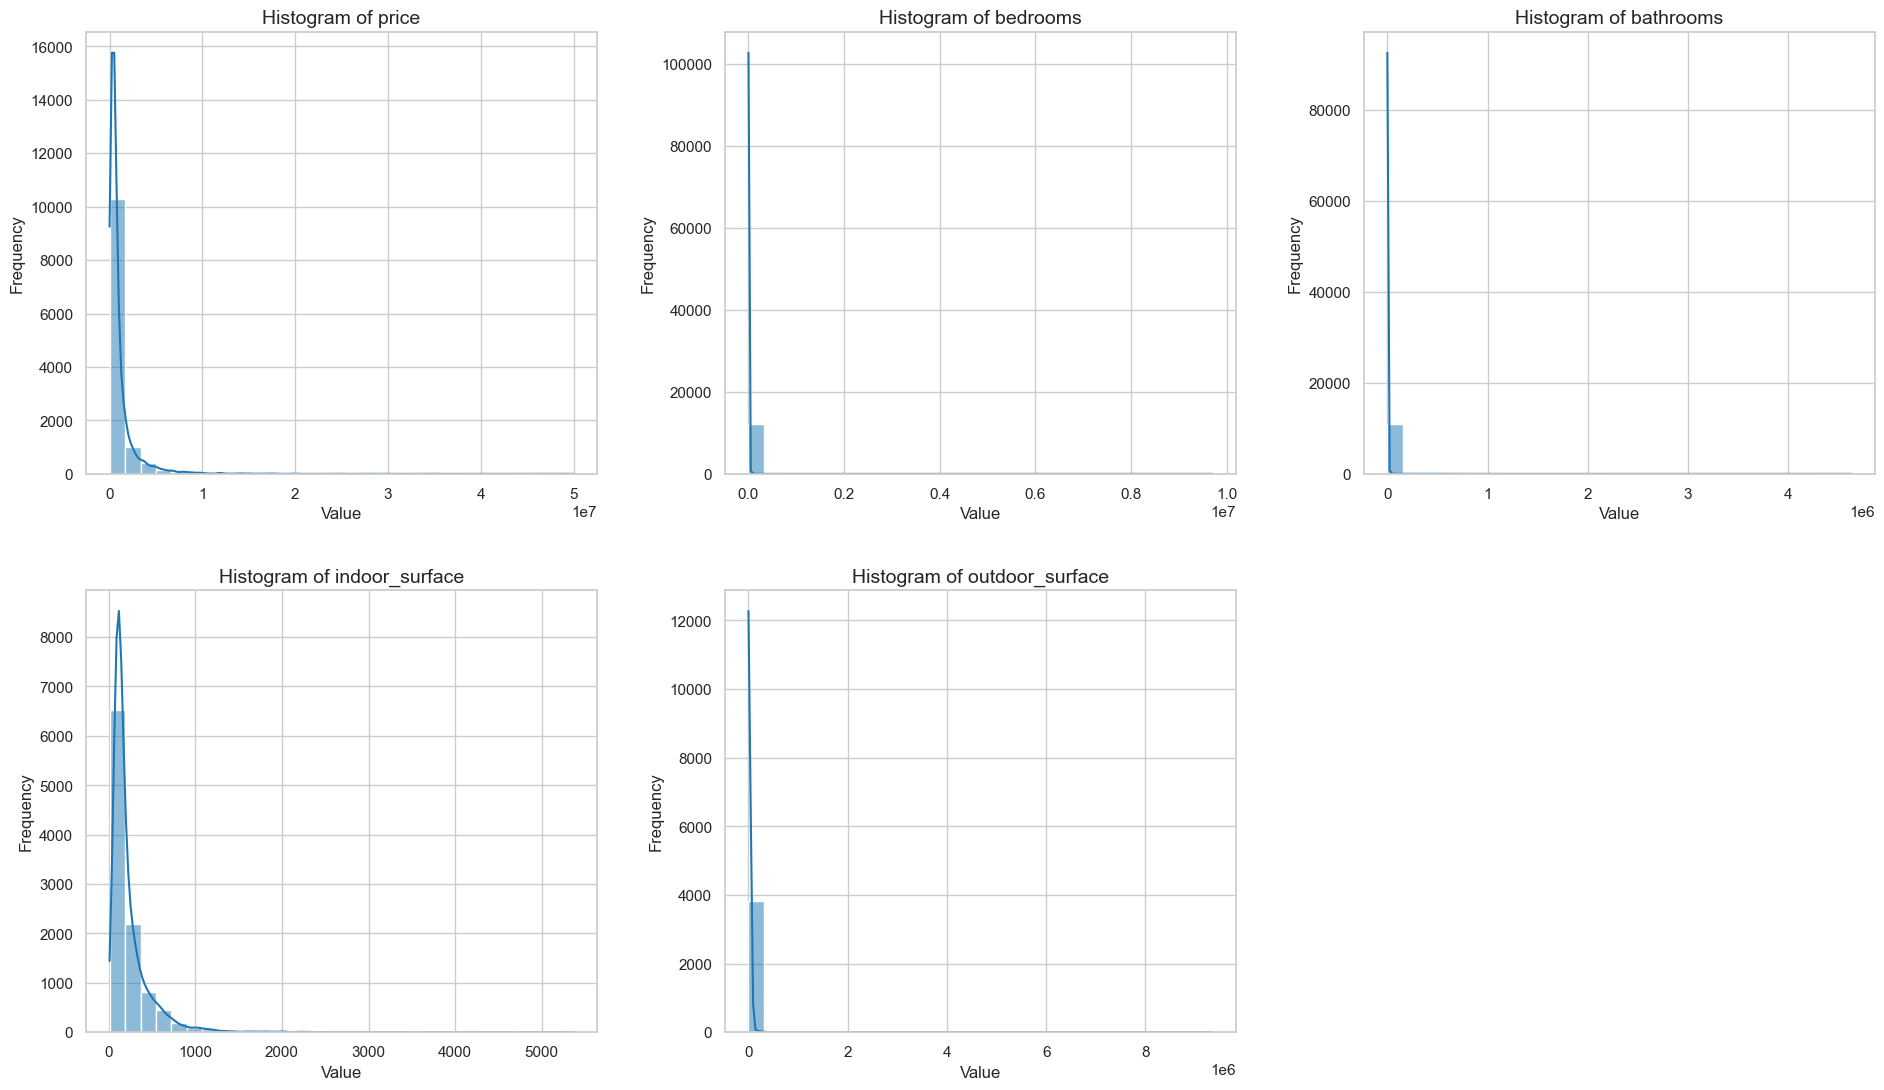

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = ax.flatten()

for i in range(len(continuousFeatures)):
    current_feature = continuousFeatures[i]
    sns.histplot(data=df, x=current_feature, bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f'Histogram of {current_feature}', fontsize=14)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig("images/histograms.pdf")
plt.show()

### Plot Relationships


Generating scatter plot for Indoor Surface vs. Price...


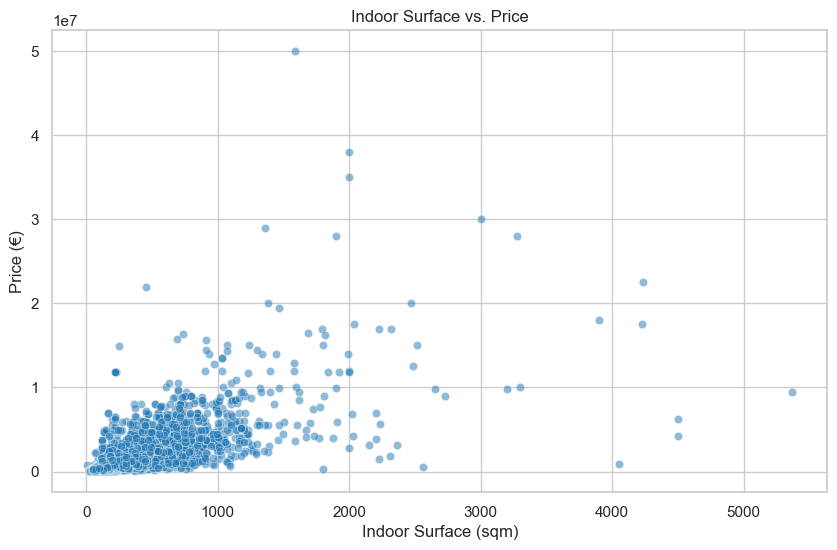


Generating box plot for Price vs Bedrooms...


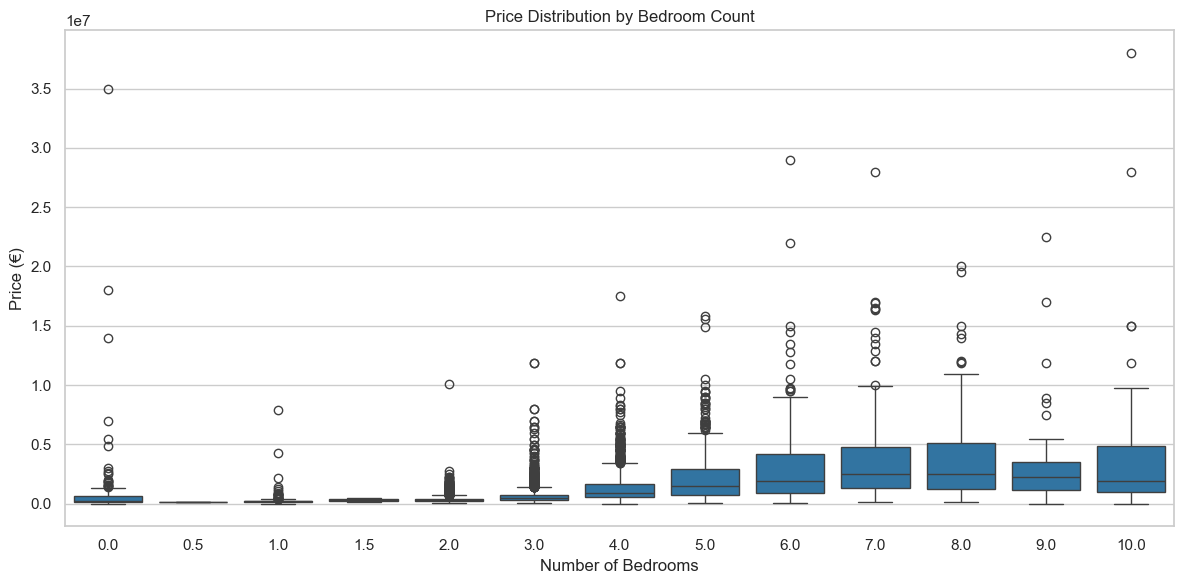


Generating Price vs Property Type...


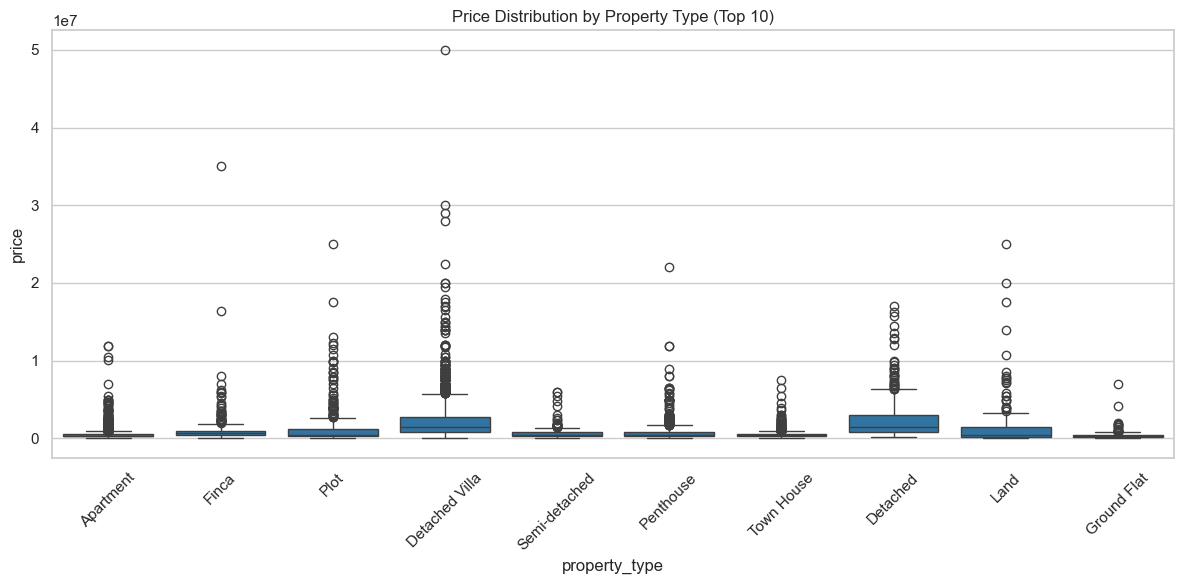


Generating Top Cities bar plot...


/tmp/ipykernel_45039/3711184661.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city', data=df, order=top_cities, palette='viridis')


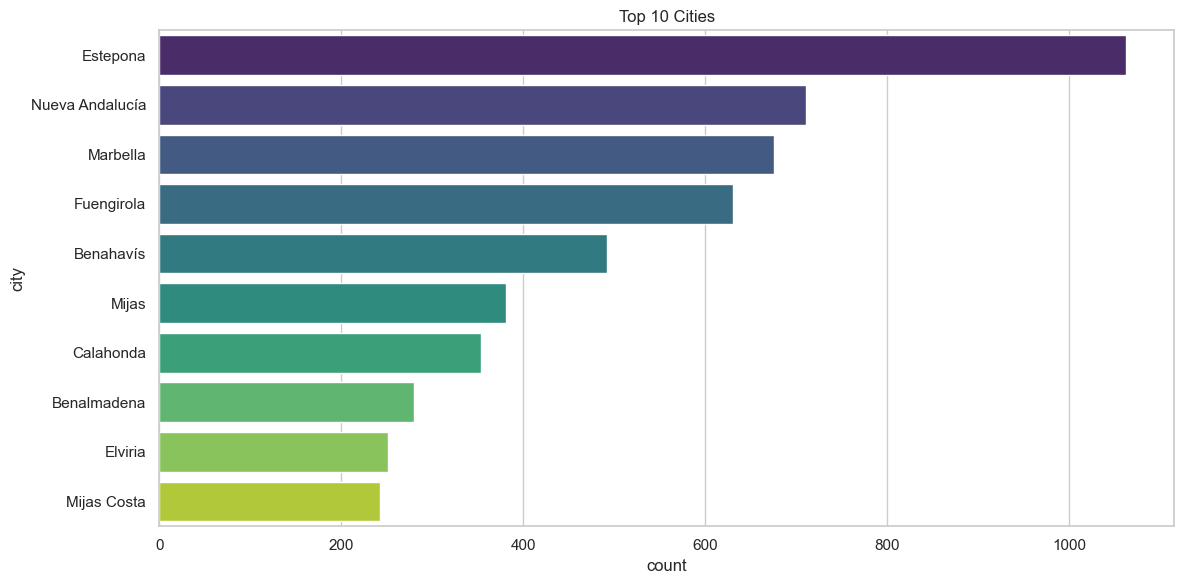


Generating Top Features bar plot...


/tmp/ipykernel_45039/3711184661.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')


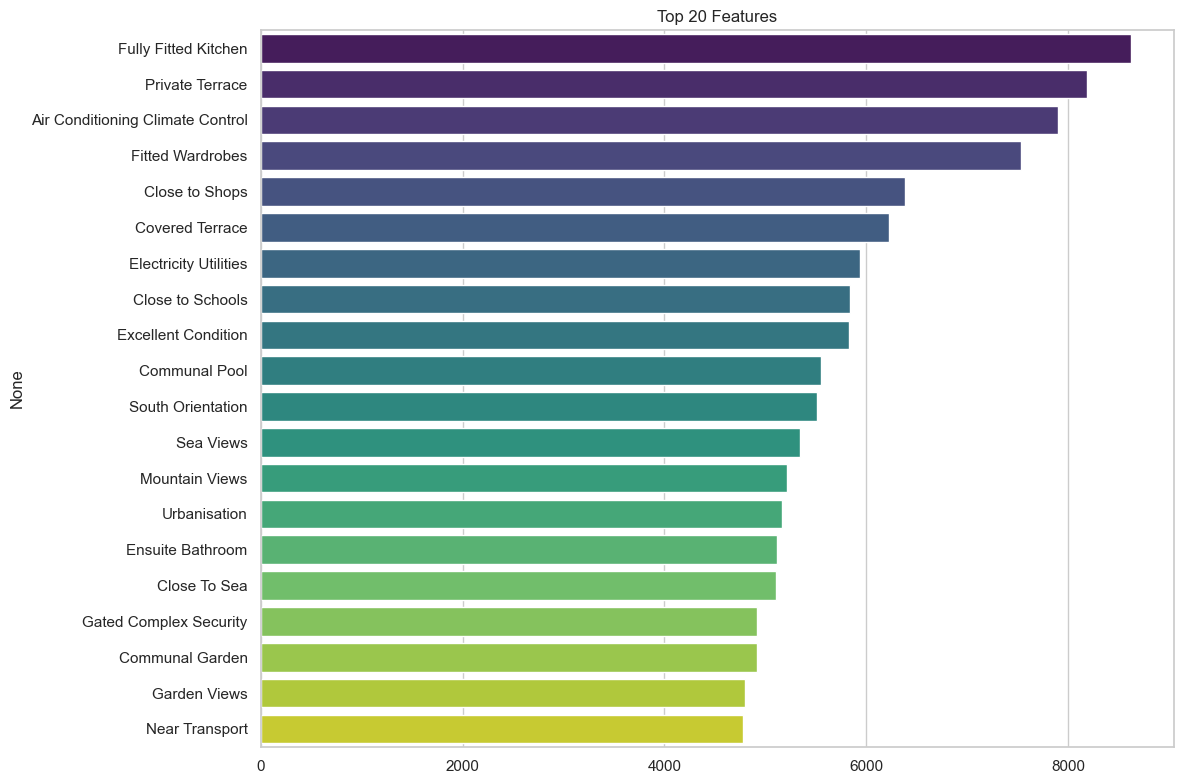


Generating bar plot for Top 10 Locations...


/tmp/ipykernel_45039/3711184661.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='location', data=df, order=top_locations, palette='viridis')


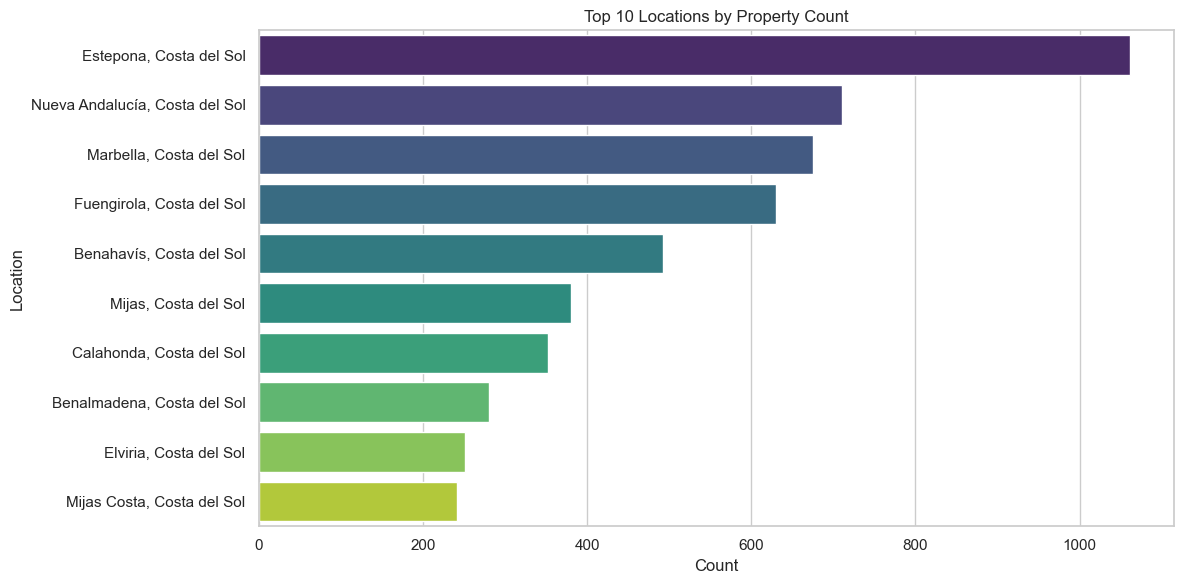


Generating bar plot for Top 20 Property Features...


/tmp/ipykernel_45039/3711184661.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')


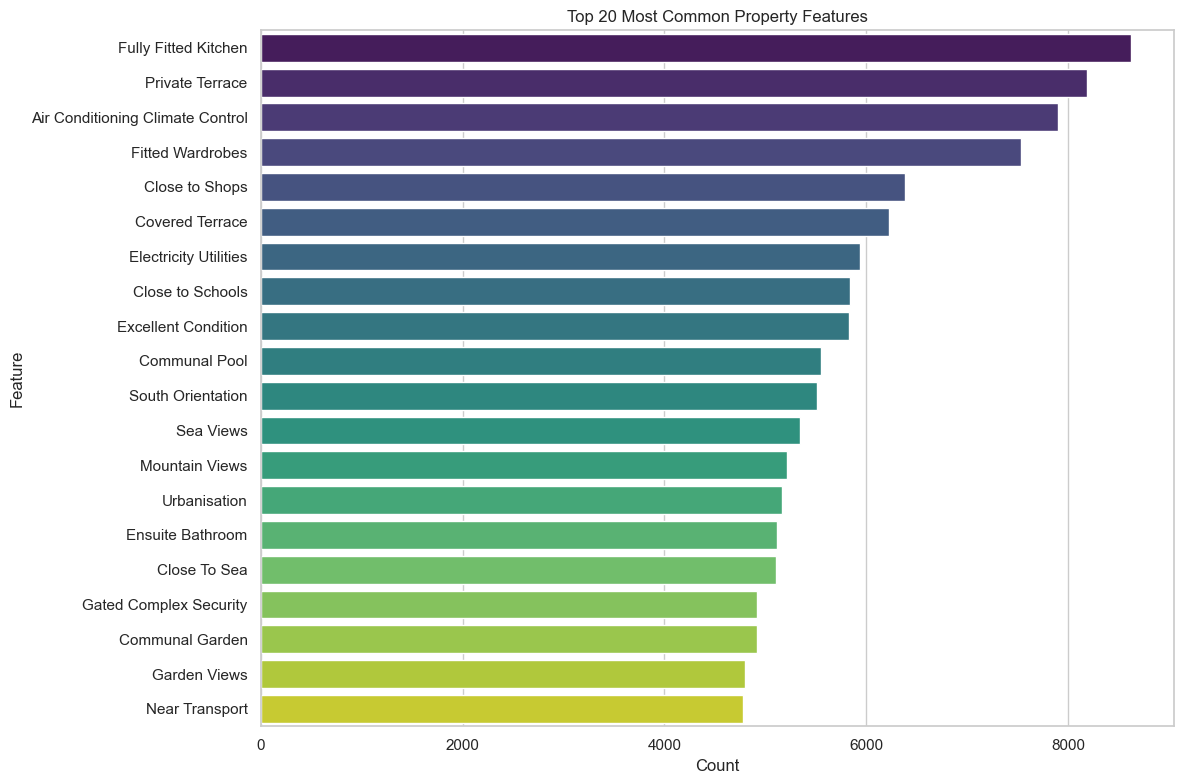

In [19]:
# Scatter Plot: Indoor Surface vs Price
print("\nGenerating scatter plot for Indoor Surface vs. Price...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='indoor_surface', y='price', alpha=0.5)
plt.xlabel('Indoor Surface (sqm)')
plt.ylabel('Price (€)')
plt.title('Indoor Surface vs. Price')
plt.savefig('images/scatter_surface_price.pdf')
plt.show()

# Box Plot: Price vs Bedrooms
print("\nGenerating box plot for Price vs Bedrooms...")
plt.figure(figsize=(12, 6))
# Filter to reasonable bedroom counts (e.g., <= 10) to keep plot readable
subset_df = df[df['bedrooms'] <= 10]
sns.boxplot(x='bedrooms', y='price', data=subset_df)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (€)')
plt.title('Price Distribution by Bedroom Count')
plt.tight_layout()
plt.savefig('images/price_vs_bedrooms.pdf')
plt.show()


# 1. Price vs Property Type 
print("\nGenerating Price vs Property Type...")
plt.figure(figsize=(12, 6))
# Filter to top 10 property types for readability
top_types = df['property_type'].value_counts().nlargest(10).index
sns.boxplot(x='property_type', y='price', data=df[df['property_type'].isin(top_types)])
plt.xticks(rotation=45)
plt.title('Price Distribution by Property Type (Top 10)')
plt.tight_layout()
plt.savefig('images/price_vs_property_type.pdf')
plt.show()

# 2. Top Cities 
print("\nGenerating Top Cities bar plot...")
plt.figure(figsize=(12, 6))
top_cities = df['city'].value_counts().nlargest(10).index
sns.countplot(y='city', data=df, order=top_cities, palette='viridis')
plt.title('Top 10 Cities')
plt.tight_layout()
plt.savefig('images/top_cities.pdf')
plt.show()

# 3. Top Features
print("\nGenerating Top Features bar plot...")
# Calculate sum of binary features
feature_sums = df[binaryFeatures].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')
plt.title('Top 20 Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

# Bar Plot: Top 10 Locations
print("\nGenerating bar plot for Top 10 Locations...")
top_locations = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.countplot(y='location', data=df, order=top_locations, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 10 Locations by Property Count')
plt.tight_layout()
plt.savefig('images/top_locations.pdf')
plt.show()

# Bar Plot: Top 20 Features (New!)
print("\nGenerating bar plot for Top 20 Property Features...")
# Sum the binary columns to get counts of each feature
feature_counts = df[binaryFeatures].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.title('Top 20 Most Common Property Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

### Pair Plots

Generating pairplot for all continuous variables...


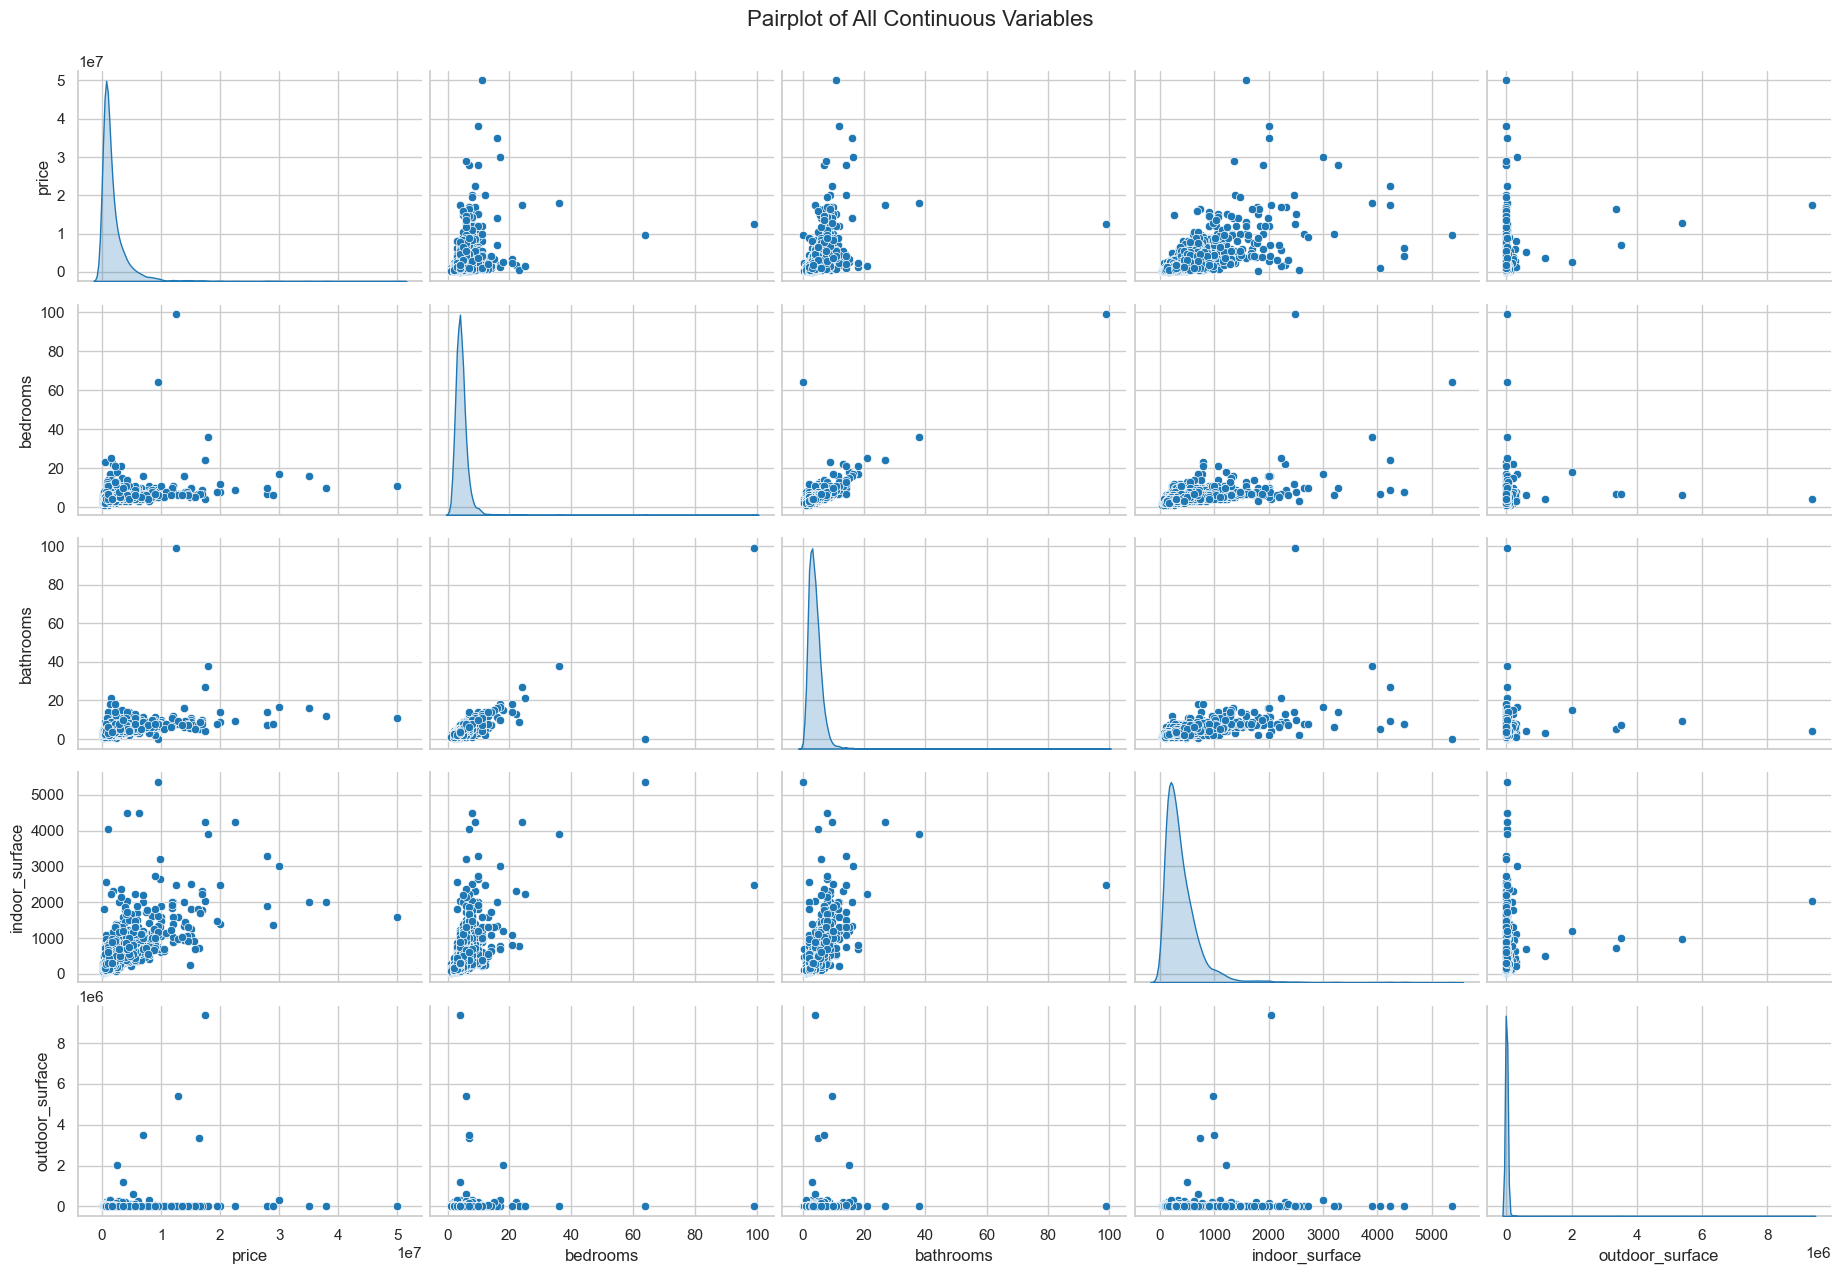

Generating count plots for all categorical variables...


/tmp/ipykernel_45039/2478664182.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


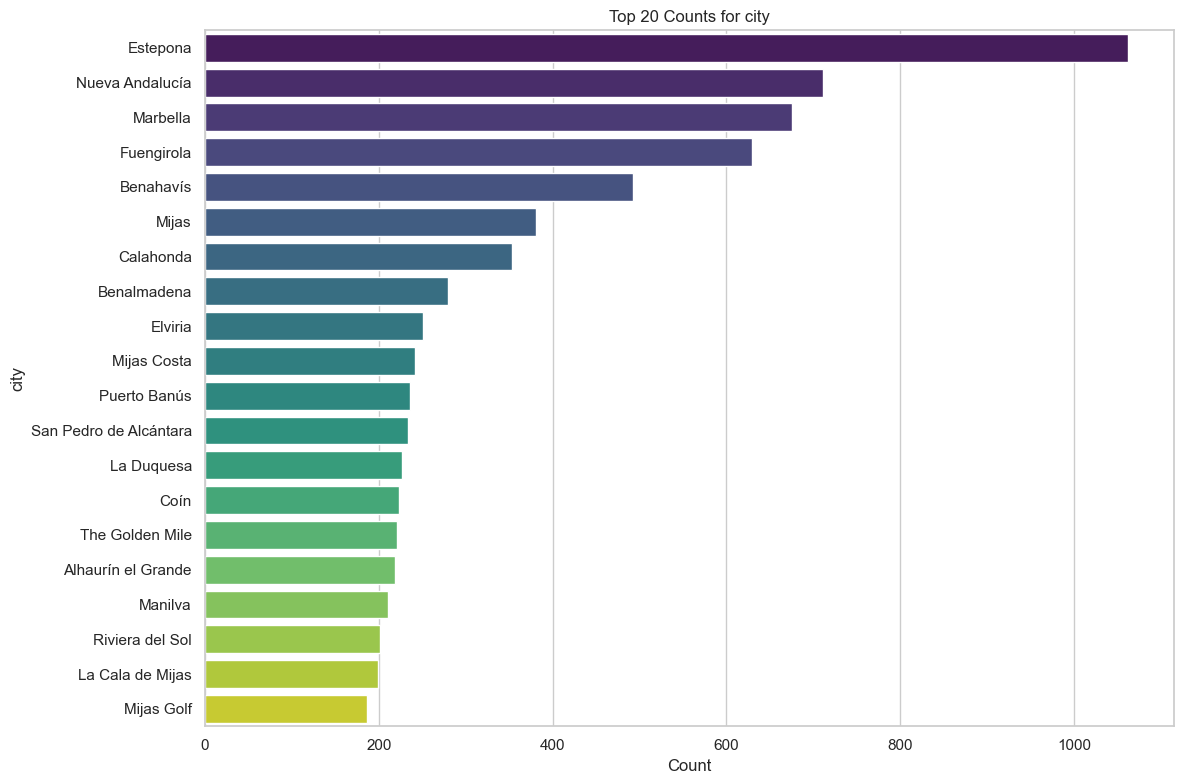

/tmp/ipykernel_45039/2478664182.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


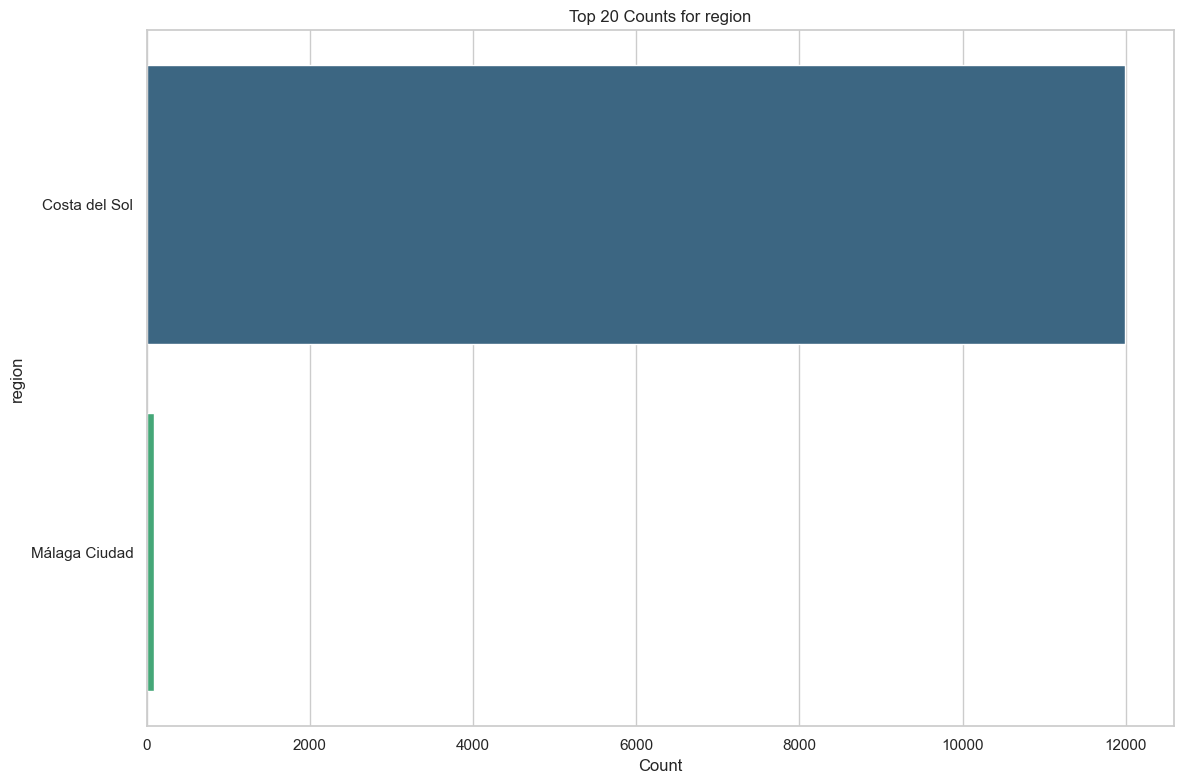

/tmp/ipykernel_45039/2478664182.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


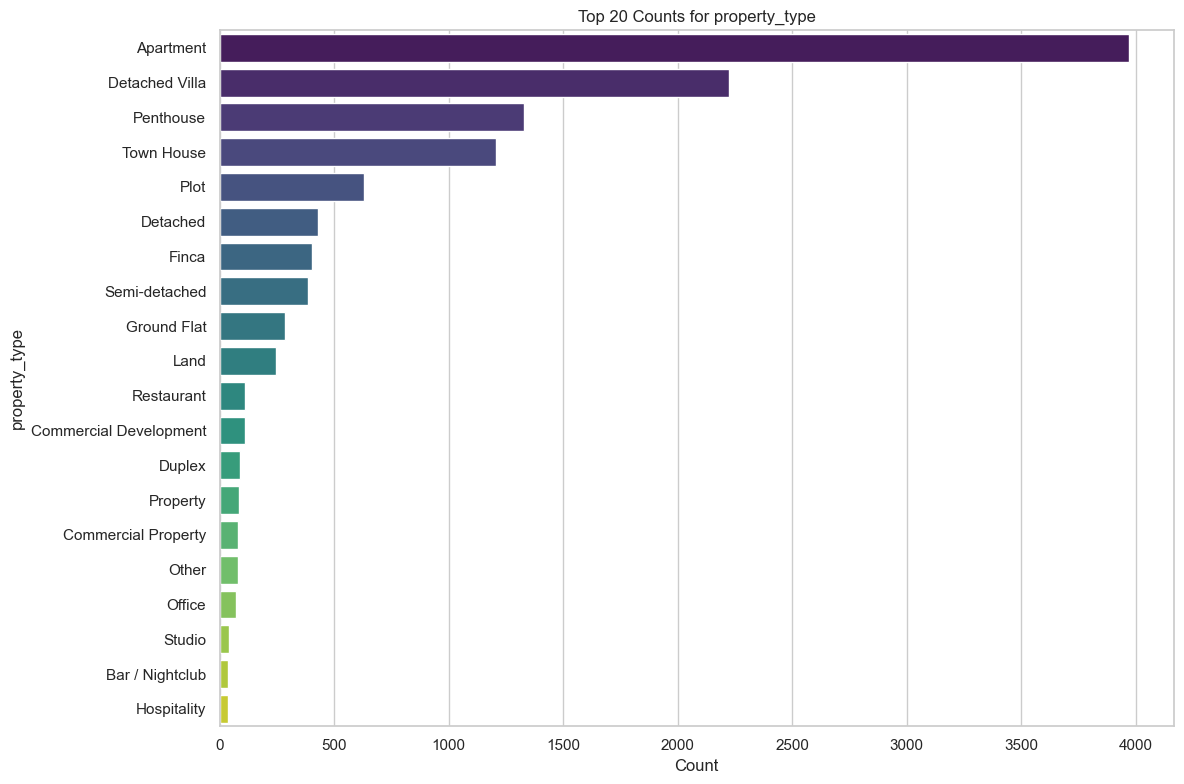

/tmp/ipykernel_45039/2478664182.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


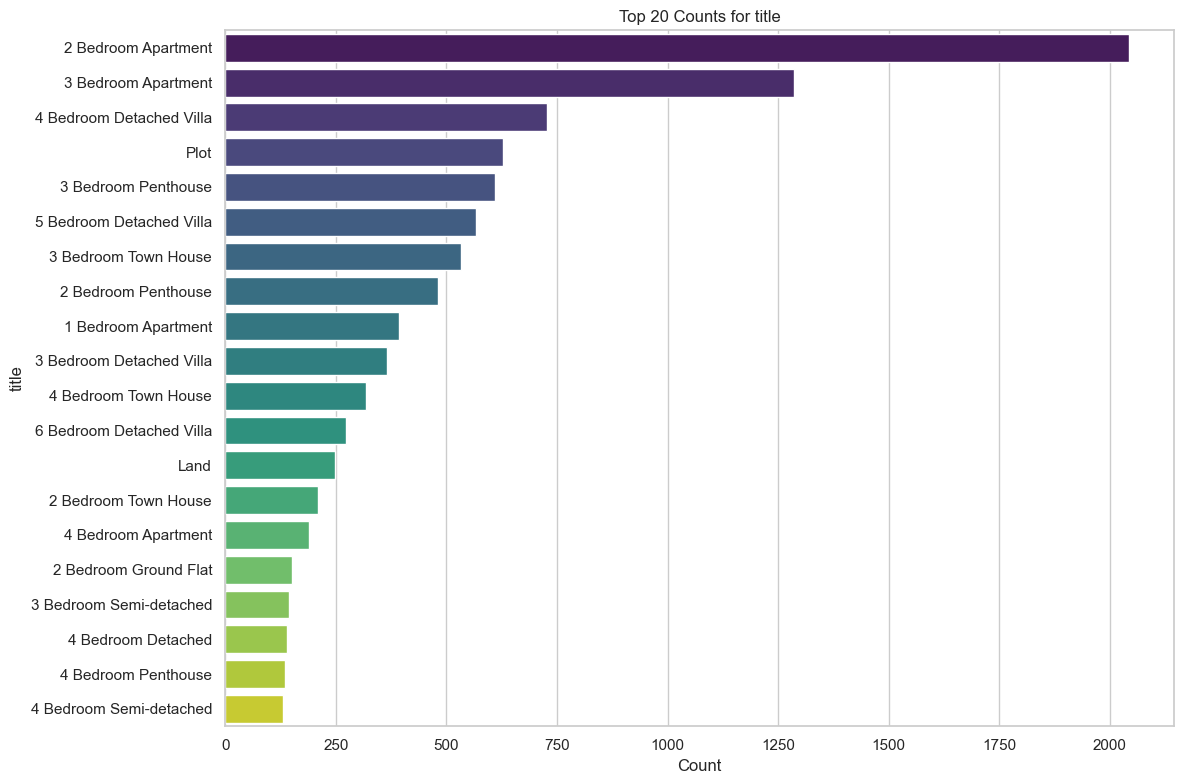

In [20]:
# --- Pairplot for ALL Continuous Variables ---
print("Generating pairplot for all continuous variables...")
sns.pairplot(df[continuousFeatures].dropna(), aspect=1.5, diag_kind='kde')
plt.suptitle('Pairplot of All Continuous Variables', y=1.02, fontsize=16)
plt.savefig('images/pairplot_all.png')
plt.show()

# --- Count Plots for ALL Categorical Variables ---
print("Generating count plots for all categorical variables...")
for col in categoricalFeatures:
    plt.figure(figsize=(12, 8))
    # Get top 20 categories to keep the plot readable
    top_categories = df[col].value_counts().nlargest(20).index
    sns.countplot(y=col, data=df, order=top_categories, palette='viridis')
    plt.title(f'Top 20 Counts for {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    # Sanitize filename
    safe_col = "".join([c for c in col if c.isalnum()])
    plt.savefig(f'images/countplot_{safe_col}.pdf')
    plt.show()
    


### Correlation Matrix

Covariance Matrix:


,price,bedrooms,bathrooms,indoor_surface,outdoor_surface
price,3.539282e+12,1.617749e+10,1.559039e+10,3.447684e+08,7.680312e+10
bedrooms,1.617749e+10,9.708442e+09,4.182144e+06,3.705881e+02,1.999662e+04
bathrooms,1.559039e+10,4.182144e+06,2.149698e+09,3.710090e+02,2.134321e+04
indoor_surface,3.447684e+08,3.705881e+02,3.710090e+02,7.025941e+04,7.401787e+06
outdoor_surface,7.680312e+10,1.999662e+04,2.134321e+04,7.401787e+06,3.844150e+10




Calculating Pearson's Correlation...


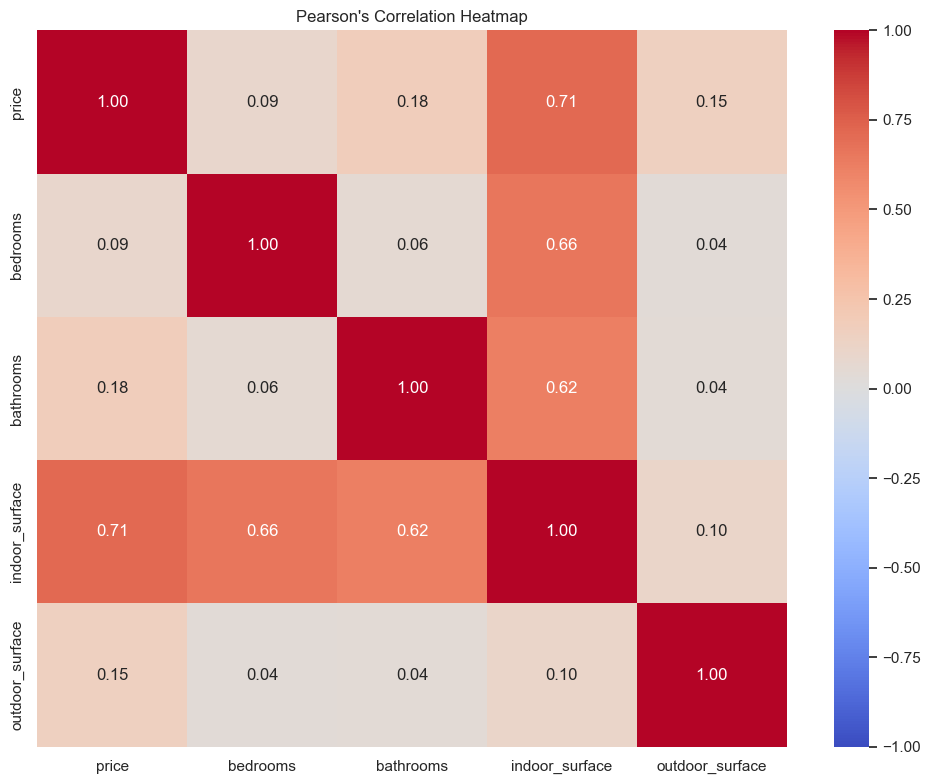

Calculating Spearman's Correlation...


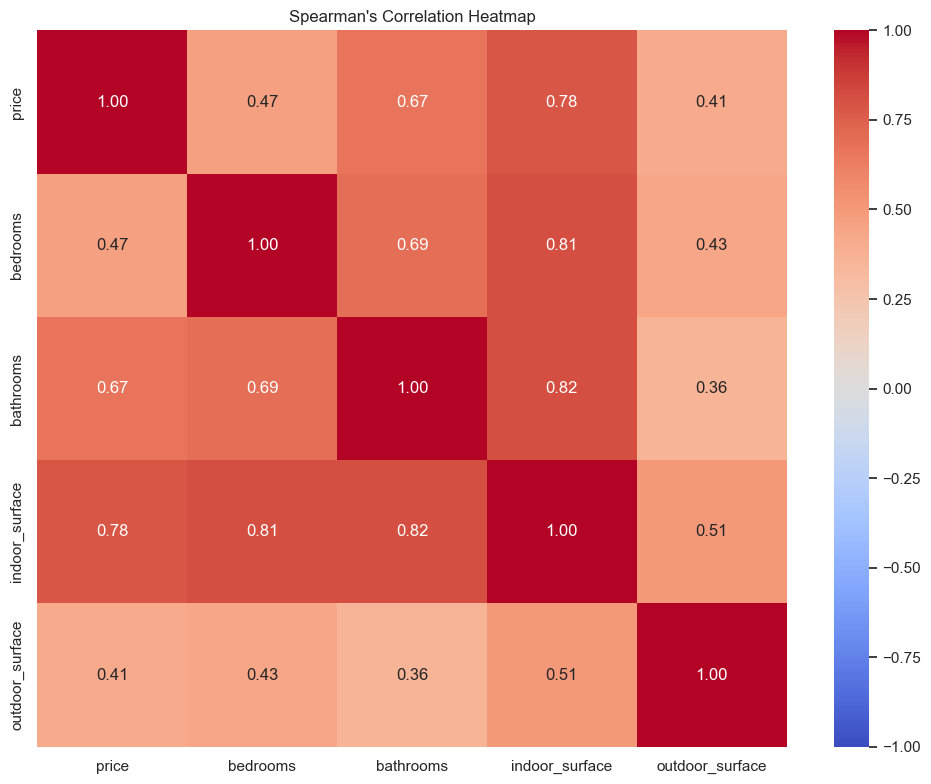

In [21]:
print("Covariance Matrix:")
covariance = df[continuousFeatures].cov()
display(covariance)
print("\n" + "="*80 + "\n") 

# --- Pearson's Correlation ---
print("Calculating Pearson's Correlation...")
plt.figure(figsize=(10, 8))
correlation = df[continuousFeatures].corr(method='pearson')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/pearson_correlation.pdf')
plt.show()

# --- Spearman's Correlation ---
print("Calculating Spearman's Correlation...")
plt.figure(figsize=(10, 8))
correlationSp = df[continuousFeatures].corr(method='spearman')
sns.heatmap(correlationSp, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/spearman_correlation.pdf')
plt.show()

# Data Prep